# Group Project:  Covid Cases and Unemployment Rate

### Group Member: Jing Duan/ Liyang Wu/Yanxu Guo

In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt  
import geopandas                         
from shapely.geometry import Point 
import seaborn as sns 

import sklearn.cluster
import statsmodels.api as sm
import sklearn

from mpl_toolkits.axes_grid1 import make_axes_locatable

import statsmodels.formula.api as smf  
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import linear_model                         
from sklearn.preprocessing import StandardScaler   

# 1. Relationship between Cases and Unemployment Rate

In [6]:
covid = pd.read_excel('UNRATE.xls', sheet_name='Sheet1', index_col=0)
covid

,unemployment_rate,new_cases
date,,
2020-01-01,3.5,7
2020-02-01,3.5,19
2020-03-01,4.4,185786
2020-04-01,14.8,875927
2020-05-01,13.3,725468
2020-06-01,11.1,840357
2020-07-01,10.2,1925041
2020-08-01,8.4,1473779
2020-09-01,7.8,1210965


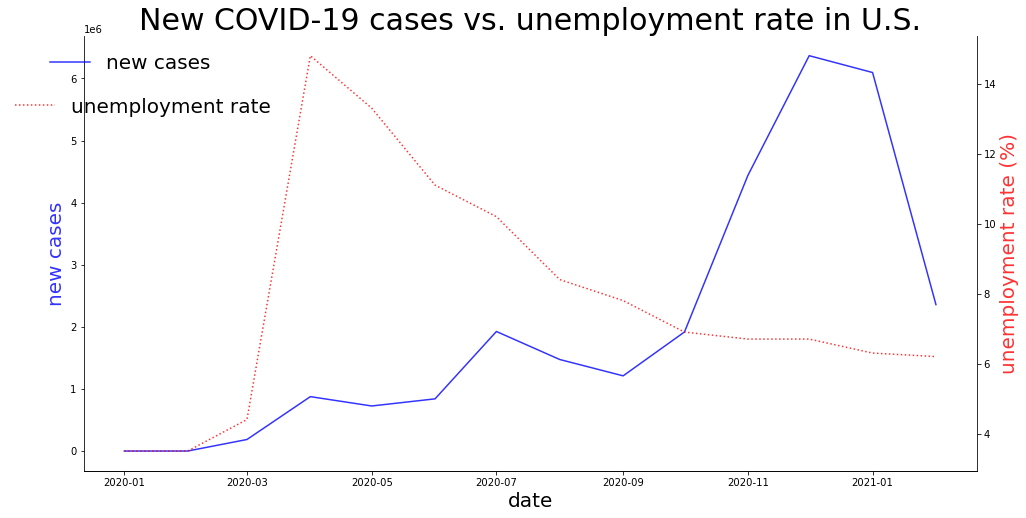

In [27]:
# from the graph, we notice there is a lag effect
fig, ax = plt.subplots(figsize=(16,8)) 
ax.plot(covid.index, covid['new_cases'],        
        color='blue', alpha = 0.8, linestyle = '-', label = 'new cases')  

ax.set_xlabel('date', fontsize=20) 
ax.FrontSize=30
ax.set_ylabel('new cases',alpha = 0.8, color='blue', fontsize=20) 
ax2 =ax.twinx() # set another y-axis as unemployment rate
ax2.Frontsize=30
ax2.plot(covid.index, covid['unemployment_rate'],
         color='red', alpha = 0.8, linestyle = ':', label = 'unemployment rate')
ax2.set_ylabel('unemployment rate (%)',alpha = 0.8, color='red', fontsize=20)
ax.set_title('New COVID-19 cases vs. unemployment rate in U.S.', fontsize = 30)

ax.spines['right'].set_visible(False) # get ride of the line on the right
ax.spines['top'].set_visible(False)   # get rid of the line on top
ax2.spines['left'].set_visible(False) # get ride of the line on the left
ax2.spines['top'].set_visible(False)   # get rid of the line on top

ax.legend(frameon=False, fontsize=20, bbox_to_anchor =(0.1615, 1))
ax2.legend(frameon=False, fontsize=20, bbox_to_anchor =(0.23, 0.9))

plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(12,8)) 
ax.scatter(covid['new_cases'], covid['unemployment_rate'],         
        color='black')  

ax.set_ylabel('unemployment rate (%)', fontsize=14)
ax.set_xlabel('new cases', fontsize=14)
ax.set_title('New COVID-19 cases vs. unemployment rate in U.S.', fontsize=16)

plt.savefig('/Users/wuliyang/Desktop/2021 Spring/Econ 570/Project/covid_scatter.png') 

plt.show()

In [69]:
# Lag Effect
# reframe as supervised learning
dataframe = pd.DataFrame()
for i in range(11,0,-1):
    dataframe['t-'+str(i)] = covid.shift(i).values[:,0]
dataframe['t'] = covid.values[:,0]
#print(dataframe.head(12))
dataframe = dataframe[12:]
dataframe

,t-11,t-10,t-9,t-8,t-7,t-6,t-5,t-4,t-3,t-2,t-1,t
12,3.5,4.4,14.8,13.3,11.1,10.2,8.4,7.8,6.9,6.7,6.7,6.3
13,4.4,14.8,13.3,11.1,10.2,8.4,7.8,6.9,6.7,6.7,6.3,6.2


In [98]:
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot
from sklearn.feature_selection import RFE

In [96]:
# split into input and outpu
df=dataframe.values
x=df[:,1:10]
y = df[:,11]
# fit random forest model
model = RandomForestRegressor(n_estimators=500, random_state=1)
model.fit(x, y)
# show importance scores
print(model.feature_importances_)
# plot importance scores
names = dataframe.columns.values[0:-3]
names
#ticks = [i for i in range(len(names))]
#pyplot.bar(ticks, model.feature_importances_)
#pyplot.xticks(ticks, names)
#pyplot.show()


[0.12592593 0.12592593 0.13333333 0.14814815 0.10740741 0.13703704
 0.1        0.12222222 0.        ]


array(['t-11', 't-10', 't-9', 't-8', 't-7', 't-6', 't-5', 't-4', 't-3'],
      dtype=object)

<BarContainer object of 9 artists>

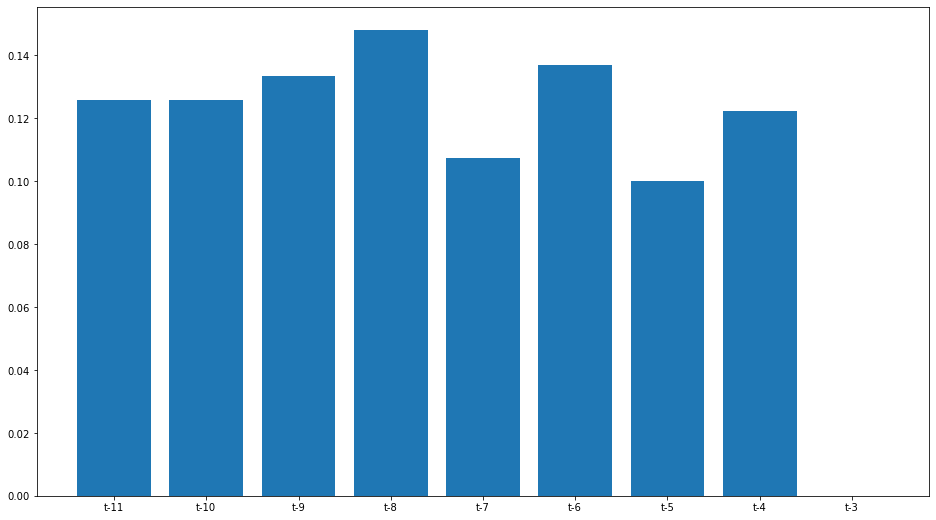

In [97]:
fig, ax = plt.subplots(figsize =(16, 9))
ax.bar(names,model.feature_importances_)

In [105]:
#feature selection for lag variables
rfe = RFE(RandomForestRegressor(n_estimators=500, random_state=1), n_features_to_select=1)
fit = rfe.fit(x, y)
print('Selected Features:')
for i in range(len(fit.support_)):
    if fit.support_[i]:
        print(names[i])

Selected Features:
t-5


<BarContainer object of 9 artists>

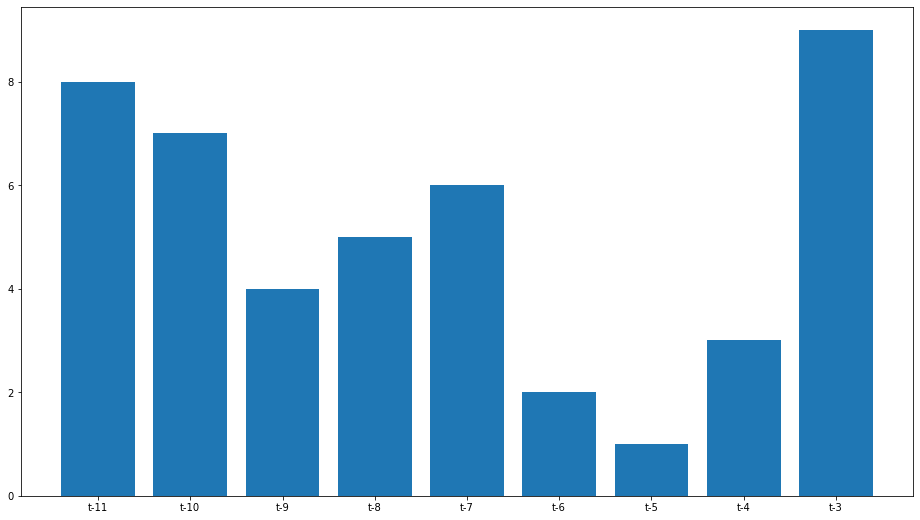

In [106]:
fig, ax = plt.subplots(figsize =(16, 9))
ax.bar(names,fit.ranking_)

# 2. Unemployment Rate accross counties

In [6]:
states = pd.read_excel("proposal.xlsx",header=0)
states.head()

In [8]:
states.dtypes
states['Cases']= states['Cases'].str.replace(',','').astype('float')

In [10]:
# finding the state with the largest number of cases
states[states['Cases']==max(states['Cases'])]

,State,2020,2021,Rate Change,Cases
4,California,4.5,9.2,4.7,3712203.0


In [9]:
# finding the state with the largest change in unimployment rate
states[states['Rate Change']==max(states['Rate Change'])]

,State,2020,2021,Rate Change,Cases
11,Hawaii,2.1,9.9,7.8,31075.0


In [11]:
states[states['Cases']>1600000]

,State,2020,2021,Rate Change,Cases
4,California,4.5,9.2,4.7,3712203.0
9,Florida,3.4,5.3,1.9,2148448.0
32,New York,4.1,9.4,5.3,2024251.0
43,Texas,3.7,7.3,3.6,2847651.0


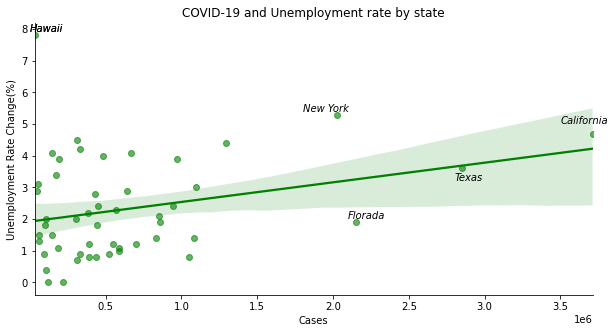

In [12]:
my_fig, my_ax = plt.subplots(figsize=(10,5)) 


my_kws={ 'alpha':0.6}

sns.regplot(x='Cases',
                                                  # column to put on x axis
            y= 'Rate Change',                     # column to put on y axis 
            data=states,      # the data
            ax = my_ax,                           # an axis object
            color = 'green', 
            logx = False,
            scatter_kws = my_kws,
            ci = 90)                             # confidence interval, 0 supresses it


sns.despine(ax = my_ax)                             

# Since this is all in a matplotlib axis/figure, our usual labeling applies.  
my_ax.set_title('COVID-19 and Unemployment rate by state')
my_ax.set_xlabel('Cases')
my_ax.set_ylabel('Unemployment Rate Change(%)')
my_ax.text(3500000, 5, 'California',  style="italic") 
my_ax.text(0, 7.9, 'Hawaii',  style="italic")
my_ax.text(0, 7.9, 'Hawaii',  style="italic")
my_ax.text(2800000, 3.2, 'Texas',  style="italic")
my_ax.text(1800000, 5.4, 'New York',  style="italic")
my_ax.text(2100000, 2, 'Florada',  style="italic") 
plt.show()


# 3. Stringency Index & Unemployment Rate

In [130]:
stringency_index = pd.read_excel('OxCGRT_timeseries_all.xlsx', 
                                 sheet_name = 'stringency_index',
                                 header = 0)

#keep only US stringency index data
stringency_index = stringency_index[stringency_index['country_name'] == 'United States']

#organize the data frame
stringency_index = stringency_index.transpose()
stringency_index = stringency_index[1:]
new_header = stringency_index.iloc[0]
stringency_index = stringency_index[1:]
stringency_index.columns = new_header
stringency_index.index = pd.to_datetime(stringency_index.index)

#keep only data from Jan. 1st, 2020 to Feb. 1st, 2021
stringency_index = stringency_index[:398]
stringency_index['United States'] = stringency_index['United States'].astype(int)
stringency_index.head()

country_name,United States
2020-01-01,0
2020-01-02,0
2020-01-03,0
2020-01-04,0
2020-01-05,0


In [131]:
#get monthly average stringency index
stringency_index_m = stringency_index.resample('m').mean()
stringency_index_m = stringency_index_m['United States'].tolist()
stringency_index_m

[0.0,
 4.827586206896552,
 45.354838709677416,
 72.0,
 72.0,
 69.86666666666666,
 67.61290322580645,
 67.0,
 63.833333333333336,
 63.67741935483871,
 69.2,
 71.12903225806451,
 71.0,
 71.0]

In [142]:
#merge unemployment rate with stringency index
unemp = pd.read_excel('UNRATE.xls', sheet_name='Sheet1')
unemp.set_index('date', inplace=True)
unemp['stringency_index'] = stringency_index_m

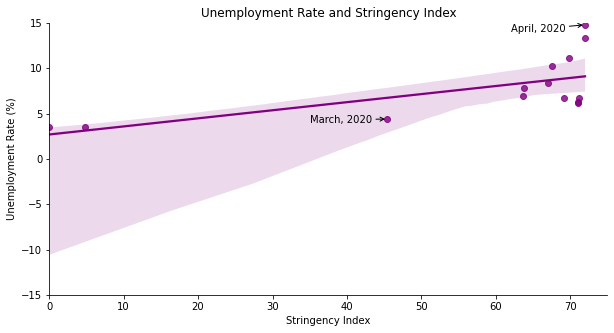

In [134]:
fig, ax = plt.subplots(figsize=(10,5))

sns.regplot(x='stringency_index',
            y='unemployment_rate', 
            data=unemp,
            ax=ax,
            color='purple',
            ci=95)

sns.despine(ax=ax)

ax.annotate('March, 2020', 
            xy=(45.4, 4.4),
            xytext=(35, 4), 
            arrowprops={'facecolor':'black',  'arrowstyle':'->'})

ax.annotate('April, 2020', 
            xy=(72, 14.8),
            xytext=(62, 14), 
            arrowprops={'facecolor':'black',  'arrowstyle':'->'})

plt.xlim(0,75)
plt.ylim(-15, 15)

ax.set_title('Unemployment Rate and Stringency Index')
ax.set_xlabel('Stringency Index')
ax.set_ylabel('Unemployment Rate (%)')


plt.show()

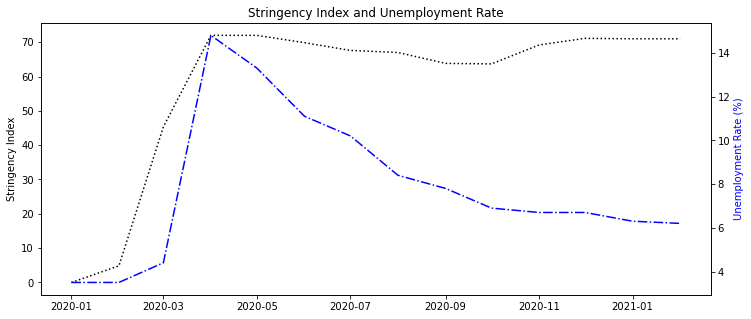

In [44]:
fig, ax1 = plt.subplots(figsize=(12,5))

ax1.plot(unemp.index, 'stringency_index', data=unemp, color='black', linestyle='dotted', label='Stringency Index')
ax1.set_ylabel('Stringency Index', color='black')

ax2 = ax1.twinx() 
ax2.plot(unemp.index, 'unemployment_rate', data=unemp, color='blue', linestyle='-.', label='Unemployment Rate')
ax2.set_ylabel('Unemployment Rate (%)', color='blue')

ax1.set_title('Stringency Index and Unemployment Rate')

plt.show()

# 4. Race and Unemployment Rate

In [120]:
race = pd.read_csv('Unem_race.csv', index_col=0)
race=race[:-1]
race

,Black & African American,White,Asian,Hispanic & Latino
date,,,,
1/1/20,6.1,3.0,3.1,4.3
2/1/20,6.0,3.0,2.4,4.4
3/1/20,6.8,3.9,4.1,6.0
4/1/20,16.7,14.1,14.5,18.9
5/1/20,16.7,12.3,14.9,17.6
6/1/20,15.3,10.1,13.9,14.5
7/1/20,14.4,9.2,11.9,12.7
8/1/20,12.8,7.4,10.6,10.5
9/1/20,12.0,7.0,8.8,10.3


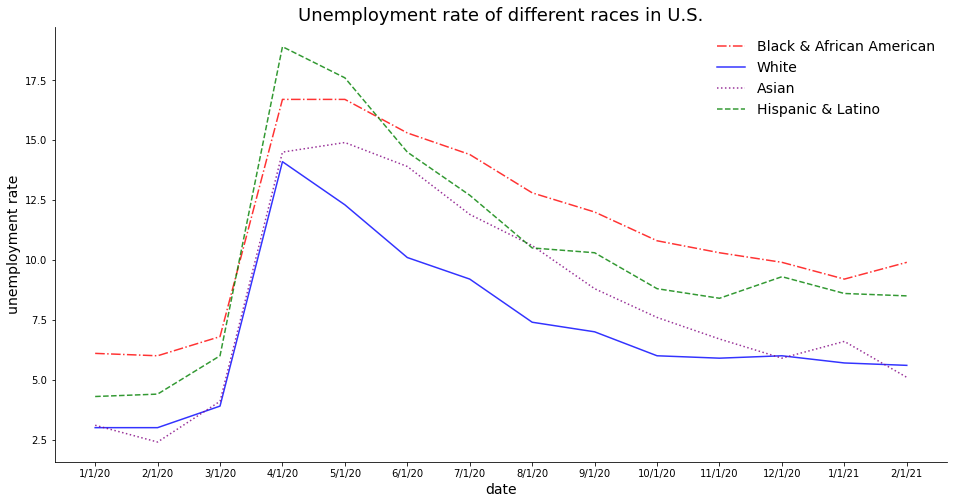

In [179]:
fig, ax = plt.subplots(figsize=(16,8)) 
ax.plot(race.index, race['Black & African American'],
        color='red', alpha = 0.8, linestyle = '-.', label = 'Black & African American')  
ax.plot(race.index, race['White'],
        color='blue', alpha = 0.8, linestyle = '-', label = 'White')
ax.plot(race.index, race['Asian'],
        color='purple', alpha = 0.8, linestyle = ':', label = 'Asian')
ax.plot(race.index, race['Hispanic & Latino'],
        color='green', alpha = 0.8, linestyle = '--', label = 'Hispanic & Latino')

ax.set_xlabel('date', fontsize = 14) 
ax.set_ylabel('unemployment rate', fontsize = 14)  

ax.set_title('Unemployment rate of different races in U.S.', fontsize = 18)

ax.spines['right'].set_visible(False) # get ride of the line on the right
ax.spines['top'].set_visible(False)   # get rid of the line on top

ax.legend(frameon=False, fontsize=14)



plt.show()

In [121]:
race_case = pd.read_csv('cases_by_race_ethnicity__all_age_groups.csv', header = 2, index_col = 0)
race_case

,Percent of cases,Count of cases,Percent of US population
Race/Ethnicity,,,
Hispanic/Latino,29.2,4566001,18.450
Asian,3.3,509366,5.760
Black,12.1,1882738,13.280
White,50.0,7816115,60.110
Others,5.6,867663,2.402


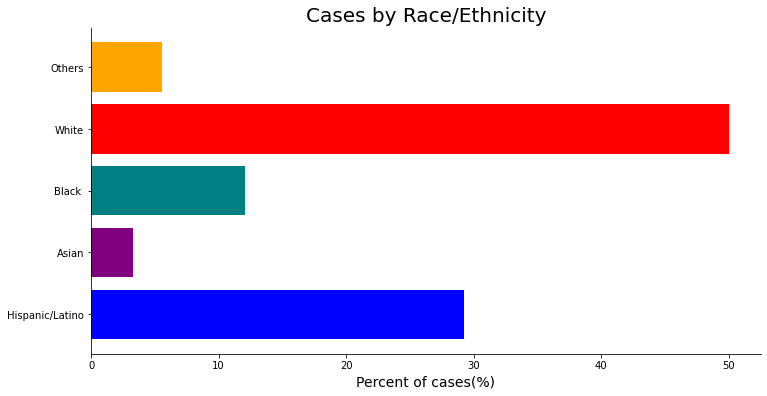

In [122]:
fig, ax = plt.subplots(figsize=(12,6)) 
New_Colors = ['blue','purple','teal','red','orange']
ax.barh(race_case.index, race_case['Percent of cases'], color=New_Colors)

ax.set_xlabel('Percent of cases(%)', fontsize=14)
ax.set_title('Cases by Race/Ethnicity', fontsize=20)

ax.spines['right'].set_visible(False) 
ax.spines['top'].set_visible(False)

plt.show()

In [123]:
race_death = pd.read_csv('deaths_by_race_ethnicity__all_age_groups.csv', header = 2, index_col = 0)
race_death

,Percent of deaths,Count of deaths,Percent of US population
Race/Ethnicity,,,
Hispanic/Latino,18.9,69848,18.450
Asian,4.0,14833,5.760
Black,14.5,53306,13.280
White,58.5,215642,60.110
Others,4.1,15067,2.402


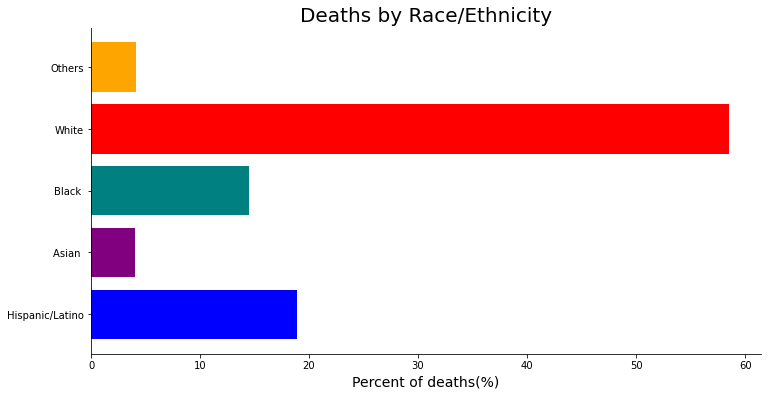

In [124]:
fig, ax = plt.subplots(figsize=(12,6)) 
New_Colors = ['blue','purple','teal','red','orange']
ax.barh(race_death.index, race_death['Percent of deaths'], color=New_Colors)

ax.set_xlabel('Percent of deaths(%)', fontsize=14)
ax.set_title('Deaths by Race/Ethnicity', fontsize=20)

ax.spines['right'].set_visible(False) 
ax.spines['top'].set_visible(False)
plt.show()

# 5. Regression Analysis 

In [162]:
#merge case/rate/stringency with Unem_race
unemp = pd.read_excel('UNRATE.xls', sheet_name='Sheet1')
unemp.set_index('date', inplace=True)
unemp['stringency_index'] = stringency_index_m

In [167]:
all=unemp
all['Black']=race['Black & African American']
all['White']=race['White']
all['Asian']=race['Asian']
all['Hispanic']=race['Hispanic & Latino']
#add lag t-5
all['t5']=('0','0','0','0','0','7','19','185786','875927','725468','740357','1917316','1473779','1210965')
all['t5']=all['t5'].astype(float)
all.head()

,unemployment_rate,new_cases,stringency_index,Black,White,Asian,Hispanic,t5
date,,,,,,,,
2020-01-01,3.5,7,0.000000,6.1,3.0,3.1,4.3,0.0
2020-02-01,3.5,19,4.827586,6.0,3.0,2.4,4.4,0.0
2020-03-01,4.4,185786,45.354839,6.8,3.9,4.1,6.0,0.0
2020-04-01,14.8,875927,72.000000,16.7,14.1,14.5,18.9,0.0
2020-05-01,13.3,725468,72.000000,16.7,12.3,14.9,17.6,0.0


In [168]:
all.dtypes

unemployment_rate    float64
new_cases              int64
stringency_index     float64
Black                float64
White                float64
Asian                float64
Hispanic             float64
t5                   float64
dtype: object

In [169]:
#regression analysis using data from 2020/0101 to 2021/02021
res = smf.ols(formula = 'unemployment_rate ~ stringency_index +Black + White + Asian + Hispanic + t5', data=all).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:      unemployment_rate   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                     6161.
Date:                Fri, 30 Apr 2021   Prob (F-statistic):           1.16e-12
Time:                        15:11:00   Log-Likelihood:                 23.408
No. Observations:                  14   AIC:                            -32.82
Df Residuals:                       7   BIC:                            -28.34
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.0918      0.155  

/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [172]:
all1=all[6:14]
all1.head()

,unemployment_rate,new_cases,stringency_index,Black,White,Asian,Hispanic,t5
date,,,,,,,,
2020-07-01,10.2,1925041,67.612903,14.4,9.2,11.9,12.7,19.0
2020-08-01,8.4,1473779,67.000000,12.8,7.4,10.6,10.5,185786.0
2020-09-01,7.8,1210965,63.833333,12.0,7.0,8.8,10.3,875927.0
2020-10-01,6.9,1917316,63.677419,10.8,6.0,7.6,8.8,725468.0
2020-11-01,6.7,4437448,69.200000,10.3,5.9,6.7,8.4,740357.0


In [178]:
res = smf.ols(formula = 'unemployment_rate ~ stringency_index', data=all).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:      unemployment_rate   R-squared:                       0.403
Model:                            OLS   Adj. R-squared:                  0.354
Method:                 Least Squares   F-statistic:                     8.117
Date:                Fri, 30 Apr 2021   Prob (F-statistic):             0.0147
Time:                        15:50:25   Log-Likelihood:                -32.980
No. Observations:                  14   AIC:                             69.96
Df Residuals:                      12   BIC:                             71.24
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            2.6947      1.951  

/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
